A multivariate LSTM (Long Short-Term Memory) model for predicting the **next day's closing stock price of Google. Unlike traditional univariate time series models, this approach incorporates multiple features ("Open", "High", "Low", "Close", "Volume") to capture more complex market dynamics.

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Google_stock_data[1].csv to Google_stock_data[1].csv
User uploaded file "Google_stock_data[1].csv" with length 493042 bytes


In [2]:
# Import Dependencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the Dataset
file_path = "Google_stock_data[1].csv"  # Make sure this file is uploaded in the runtime

# Read the CSV file
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select Features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features]

# Display the first few rows
print(data.head())


                Open      High       Low     Close     Volume
Date                                                         
2004-08-19  2.475947  2.576470  2.375919  2.484366  897427216
2004-08-20  2.500954  2.700763  2.488327  2.681699  458857488
2004-08-23  2.742112  2.809705  2.700021  2.708686  366857939
2004-08-24  2.754243  2.763156  2.564338  2.596526  306396159
2004-08-25  2.598754  2.674023  2.572014  2.624504  184645512


Normalization and sequence creation.


In [3]:
# Normalize the Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create Sequences for LSTM

def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 3])  # 'Close' is the 4th column, index 3
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(scaled_data, window_size=window_size)

# Display shapes
print("Input shape:", X.shape)
print("Target shape:", y.shape)


Input shape: (5206, 30, 5)
Target shape: (5206,)


 Splitting the data into training/testing sets and building the LSTM model

In [4]:
# Train-Test Split
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (4685, 30, 5)
Testing set shape: (521, 30, 5)


Build and train the LSTM model.

In [5]:
# Build and Train the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0050 - val_loss: 0.0010
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.2283e-04 - val_loss: 8.5696e-04
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.3206e-04 - val_loss: 5.1604e-04
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 3.3290e-04 - val_loss: 0.0011
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.4340e-04 - val_loss: 0.0024
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.2292e-04 - val_loss: 5.7906e-04
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.6289e-04 - val_loss: 8.0926e-04
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.2234e-04 - val_loss: 4.5509e-04
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.5446e-04 - val_loss: 4.7739e-04
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.6071e-04 - val_loss: 7.6382e-04
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.4

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


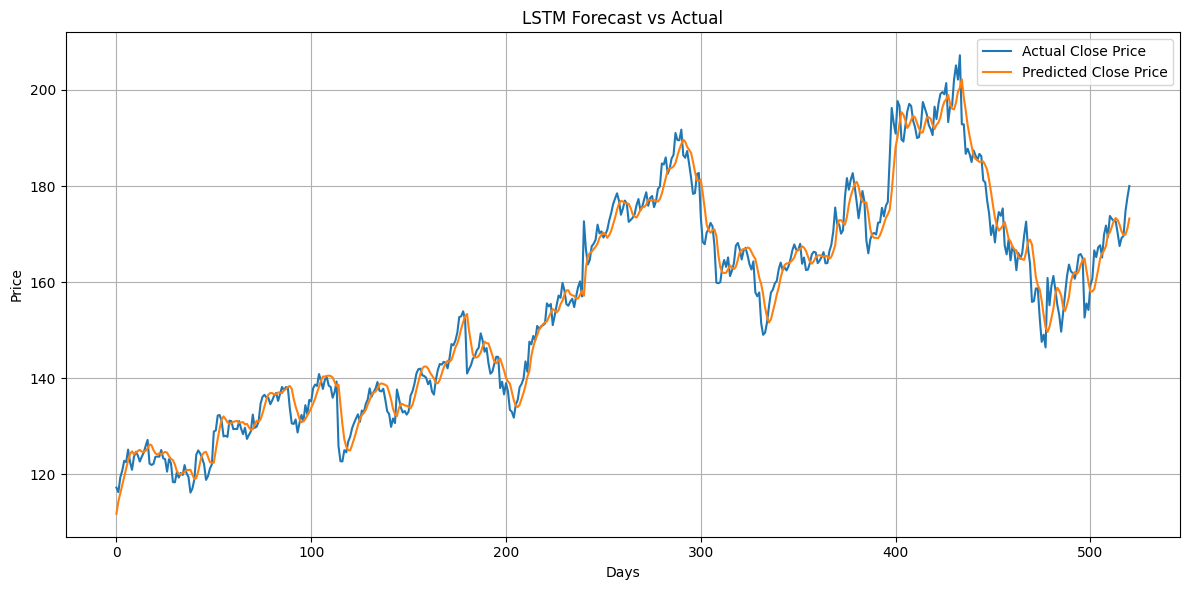

In [6]:
# Evaluate the Model
# Predict on test set
y_pred_scaled = model.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)

# Inverse transform predictions (replacing Close in scaled dataset)
def inverse_transform_close(pred_close_scaled):
    dummy = np.zeros((len(pred_close_scaled), 5))
    dummy[:, 3] = pred_close_scaled.ravel()
    return scaler.inverse_transform(dummy)[:, 3]

predicted_close = inverse_transform_close(y_pred_scaled)
actual_close = inverse_transform_close(y_test_scaled)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Close Price')
plt.plot(predicted_close, label='Predicted Close Price')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Compute RMSE and MAE

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
mae = mean_absolute_error(actual_close, predicted_close)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 3.78
MAE: 2.84


These scores suggest your model has learned meaningful patterns from all 5 input features and generalizes well.